# Synheat Model from Yee and Grossmann

    - This model designs a heat exchanger network which operates at minimal annual cost and satisfies heating and cooling requirements. The superstructure consists of two stages with eight possible exchangers.

    - GAMS code: https://www.gams.com/latest/gamslib_ml/libhtml/gamslib_synheat.html
    
    - Original paper: Yee, T F, and Grossmann, I E, Simultaneous Optimization of Models for Heat Integration - Heat Exchanger Network Synthesis. Computers and Chemical Engineering 14, 10 (1990), 1151-1184.
    
    - Multiperiod problem: Escobar, M., Trierweiler, J. O., Grossmann, I. E. A heuristic Lagrangean approach for the synthesis of multiperiod heat exchanger networks. Applied Thermal Engineering 63 (1), pp. 177-191, 2014.
    
    - MINLP solvers for Pyomo: https://scicomp.stackexchange.com/questions/40740/python-solvers-for-minlp-in-pyomo-in-google-colab
    
    - Expanded model for phase-change streams: https://www.sciencedirect.com/science/article/abs/pii/S0098135407002621?via%3Dihub
    
    - Expanded model for heat pumps: 
    
    

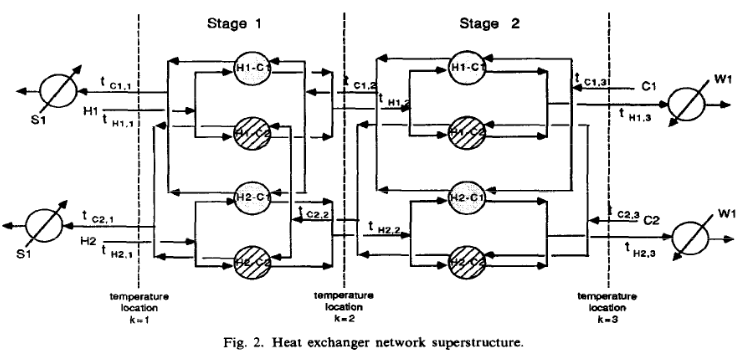

In [1]:
import numpy as np
from pyomo.environ import *
import pandas as pd
# import pyomo.environ as pyo
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

In [2]:
'''Sets'''
# nt = 
# #index sets
# t_set = np.arange(24)  # time steps (start with 1 day (24), then 1 week (168), then 1 month (744), then 1 year (8760) )

ni = 2  # number of hot streams
nj = 2  # number of cold streams
ns = 2  # number of stages in superstructure
nk = ns + 1  # number of temperature nodes in each stage

I = np.arange(ni)
J = np.arange(nj)
K = np.arange(nk)
Ks = np.arange(nk-1)

In [3]:
'''Parameters'''

# Initializing vectors
fh = np.zeros(ni)         # heat capacity flowrate of hot stream
fc = np.zeros(nj)         # heat capacity flowrate of cold stream
thin = np.zeros(ni)       # supply temp. of hot stream
thout = np.zeros(ni)      # target temp. of hot stream
tcin = np.zeros(nj)       # supply temp. of cold stream
tcout = np.zeros(nj)      # target temp. of cold stream
ech = np.zeros(ni)        # heat content hot i
ecc = np.zeros(nj)        # heat content cold j
hh = np.zeros(ni)         # stream-individual film coefficient hot i
hc = np.zeros(nj)         # stream-individual film coefficient cold j
gamma = np.zeros((ni, nj)) 

# Hot process stream 1
thin[0] = 650
thout[0] = 370
fh[0] = 10 
hh[0] = 1
# Hot process stream 2
thin[1] = 590
thout[1] = 370 
fh[1] = 20 
hh[1] = 1
# Cold process stream 1
tcin[0] = 410 
tcout[0] = 650 
fc[0] = 15
hc[0] = 1
# Cold process stream 2
tcin[[1]] = 350
tcout[1] = 500
fc[1] = 13
hc[1] = 1

# costs and coefficients
# cost of heating/cooling utility ($/?)
hucost = 80
cucost = 15

# area cost coefficient for heaters/coolers ($/m2) 
hucoeff = 150
cucoeff = 150

# inlet/outlet temperature hot/cold utility (do we need the utility )
thuin = 680
thuout = 680
tcuin = 300
tcuout = 320

# stream-individual film coefficient hot/cold utility
hhu = 5
hcu = 1

# fixed charge for heat exchanger ($/unit)
unitc = 5500

# area cost coefficient for heat exchangers ($/m2)
acoeff = 150

# cost exponent for exchangers
aexp  = 1

# minimum approach temperature
tmapp  = 10

# heat content of hot and cold streams
ecc = fc*(tcout - tcin)
ech = fh*(thin - thout)

for i in I:
    for j in J:
        # upper bound of driving force
        gamma[i, j] = max(0, tcin[j] - thin[i], tcin[j] - thout[i],tcout[j] - thin[i], tcout[j] - thout[i])


In [4]:
'''Decision Variables'''

def initialize_model():
    
    m = ConcreteModel()
    
    # Positive Variables
    m.th = Var(I, K, within=NonNegativeReals)  # temperature of  hot stream i as it enters stage k
    m.tc = Var(J, K, within=NonNegativeReals)  # temperature of cold stream j as it leaves stage k
    m.q = Var(I, J, K, within=NonNegativeReals)  # energy exchanged between i and j in stage k
    m.qc = Var(I, within=NonNegativeReals)  # energy exchanged between i and the cold utility
    m.qh = Var(J, within=NonNegativeReals)  # energy exchanged between j and the hot utility
    m.dt = Var(I, J, K, within=NonNegativeReals)  # approach between i and j at location k
    m.dtcu = Var(I, within=NonNegativeReals)  # approach between i and the cold utility
    m.dthu = Var(J, within=NonNegativeReals)  # approach between j and the hot utility
    m.fixed_charges = Var(within=NonNegativeReals)
    m.area_cost = Var(within=NonNegativeReals)
    m.utility_cost = Var(within=NonNegativeReals)
    
    # Binary Variables
    m.z = Var(I, J, K, within=Binary)  
    m.zcu = Var(I, within=Binary)  
    m.zhu = Var(J, within=Binary)  

    return m

In [9]:
'''Constraints'''
m = initialize_model()

# total energy exchanged by hot  stream i
def teh_rule(m, i):
    return (thin[i]  - thout[i])*fh[i] == sum(m.q[i, j, k] for j in J for k in Ks) + m.qc[i]
m.teh_constraint = Constraint(I, rule=teh_rule)

# total energy exchanged by cold  stream j
def tec_rule(m, j):
    return (tcout[j] - tcin[j])*fc[j]  == sum(m.q[i, j, k] for i in I for k in Ks) + m.qh[j]
m.tec_constraint = Constraint(J, rule=tec_rule)

# energy exchanged by hot  stream i in stage k
def eh_rule(m, i, k):
    if k < nk-1:
        return fh[i]*(m.th[i, k] - m.th[i, k+1]) == sum(m.q[i, j, k] for j in J)
    else:
        return Constraint.Skip
m.eh_constraint = Constraint(I, K, rule=eh_rule)

# energy exchanged by cold stream j in stage k
def ec_rule(m, j, k):
    if k < nk-1:
        return fc[j]*(m.tc[j, k] - m.tc[j, k+1]) == sum(m.q[i, j, k] for i in I)
    else:
        return Constraint.Skip
m.ec_constraint = Constraint(J, K, rule=ec_rule)

# energy exchanged by hot  stream i with the cold utility
def eqc_rule(m, i):
    return fh[i]*(m.th[i, nk-1] - thout[i])  == m.qc[i]
m.eqc_constraint = Constraint(I, rule=eqc_rule)

# energy exchanged by cold stream j with the hot utility
def eqh_rule(m, j):
    return fc[j]*(tcout[j] - m.tc[j, 0]) == m.qh[j]
m.eqh_constraint = Constraint(J, rule=eqh_rule)

# supply temperature of hot and cold streams
def tinh_rule(m, i):
    return thin[i] == m.th[i, 0]
m.tinh_constraint = Constraint(I, rule=tinh_rule)

def tinc_rule(m, j):
    return tcin[j] == m.tc[j, nk-1]
m.tinc_constraint = Constraint(J, rule=tinc_rule)

# monotonicity of m.th
def month_rule(m, i, k):
    if k < nk-1:
        return m.th[i, k] >= m.th[i, k+1]
    else:
        return Constraint.Skip
m.month_constraint = Constraint(I, K, rule=month_rule)

# monotonicity of m.tc
def montc_rule(m, j, k):
    if k < nk-1:
        return m.tc[j, k] >= m.tc[j, k+1]
    else:
        return Constraint.Skip
m.montc_constraint = Constraint(J, K, rule=montc_rule)

# monotonicity of m.th k = last
def monthl_rule(m, i):
    return m.th[i, nk-1] >= thout[i]
m.monthl_constraint = Constraint(I, rule=monthl_rule)

# monotonicity of m.tc for k = 1
def montcf_rule(m, j):
    return tcout[j] >= m.tc[j, 0]
m.montcf_constraint = Constraint(J, rule=montcf_rule)

# logical constraints on  m.q
def logq_rule(m, i, j, k):
    if k < nk-1:
        return m.q[i, j, k] - min(ech[i], ecc[j])*m.z[i, j, k] <= 0
    else:
        return Constraint.Skip
m.logq_constraint = Constraint(I, J, K, rule=logq_rule)

# logical constraints on m.qh[j] and m.qc[i]
def logqc_rule(m, i):
    return m.qc[i] - ech[i]*m.zcu[i] <= 0
m.logqc_constraint = Constraint(I, rule=logqc_rule)

def logqh_rule(m, j):
    return m.qh[j] - ecc[j]*m.zhu[j] <= 0
m.logqh_constraint = Constraint(J, rule=logqh_rule)

# logical constraints on m.dt at the hot and cold ends
def logdth_rule(m, i, j, k):
    if k < nk-1:
        return m.dt[i, j, k] <= m.th[i, k] - m.tc[j, k] + gamma[i, j]*(1 - m.z[i, j, k])
    else:
        return Constraint.Skip
m.logdth_constraint = Constraint(I, J, K, rule=logdth_rule)

def logdtc_rule(m, i, j, k):
    if k < nk-1:
        return m.dt[i, j, k+1] <= m.th[i, k+1] - m.tc[j, k+1] + gamma[i, j]*(1 - m.z[i, j, k])
    else:
        return Constraint.Skip
m.logdtc_constraint = Constraint(I, J, K, rule=logdtc_rule)

# logical constraints on m.dtcu and m.dthu
def logdthu_rule(m, j):
    return m.dthu[j] <= (thuout - m.tc[j, 0])
m.logdthu_constraint = Constraint(J, rule=logdthu_rule)

def logdtcu_rule(m, i):
    return m.dtcu[i] <= m.th[i, nk-1] - tcuout
m.logdtcu_constraint = Constraint(I, rule=logdtcu_rule)

def utility_cost_rule(m):
    return m.utility_cost == sum(m.qh[j]*hucost for j in J) + sum(m.qc[i]*cucost for i in I)
m.utility_cost_constraint = Constraint(rule=utility_cost_rule)

def area_cost_rule(m):
    return m.area_cost == acoeff*sum((m.q[i, j, k]*((1/hh[i]) + (1/hc[j]))/(((m.dt[i, j, k]*m.dt[i, j, k+1]*(m.dt[i, j, k] + m.dt[i, j, k+1])/2 +  1e-6)**0.33333) + 1e-6) + 1e-6)**aexp for i in I for j in J for k in Ks)  + \
                          hucoeff*(sum((m.qh[j]*((1/hc[j]) + 1/hhu))/(((thuin - tcout[j])*m.dthu[j]*((thuin - tcout[j] + m.dthu[j])/2) +  1e-6)**0.33333) + 1e-6 for j in J)**aexp) + \
                          cucoeff*(sum((m.qc[i]*((1/hh[i]) + (1/hcu))/(((thout[i]-tcuin)*m.dtcu[i]*(thout[i] - tcuin + m.dtcu[i])/2) +  1e-6)**0.33333) + 1e-6 for i in I)**aexp)
area_cost_constraint = Constraint(rule=area_cost_rule)

def fixed_charges_rule(m):
    return m.fixed_charges == unitc*(sum(m.z[i, j, k] for i in I for j in J for k in Ks) + sum(m.zcu[i] for i in I) + sum(m.zhu[j] for j in J))
m.fixed_charges_constraint = Constraint(rule=fixed_charges_rule)

def ObjRule(m):
#     return m.fixed_charges + m.area_cost + m.utility_cost
    return m.utility_cost
m.obj = Objective(rule=ObjRule)

In [10]:
# initial values
for i in I:
    m.th[i, :] = thin[i];
    m.dtcu[i] = thin[i] - tcuout;

for j in J:
    m.tc[j, :] = tcin[j];
    m.dthu[j]  = thuout - tcin[j];

for i in I:
    for j in J:
        for k in Ks:
            m.q[i, j, k] = min(ech[i], ecc[j])
        
        for k in K:
            m.dt[i, j, k] = thin[i] - tcin[j]

In [16]:
# opt = SolverFactory('ipopt')
opt = SolverFactory('bonmin.exe')
results = opt.solve(m, tee=True)
results.write()

Bonmin 1.8.8 using Cbc 2.10.5 and Ipopt 3.12.13
bonmin: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 24750       16 0.018
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 53249.996       16 0.01
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 53249.996        8 0.006
Cbc0012I Integer solution of 53249.996 found by DiveMIPFractional after 0 iterat

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 54
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: bonmin\x3a Optimal
  Termination condition: optimal
  Id: 3
  Error rc: 0
  Time: 1.7951898574829102
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [12]:
# assigning results
th = np.zeros((ni, nk))
tc = np.zeros((nj, nk))
q = np.zeros((ni, nj, nk))
qc = np.zeros(ni)
qh = np.zeros(nj)
dt = np.zeros((ni, nj, nk))
dtcu = np.zeros(ni)
dthu = np.zeros(nj)
z = np.zeros((ni, nj, nk))
zcu = np.zeros(ni) 
zhu = np.zeros(nj) 

fixed_charges = m.fixed_charges.value
area_cost = m.area_cost.value
utility_cost = m.utility_cost.value

for i in I:
    qc[i] = m.qc[i].value
    dtcu[i] = m.dtcu[i].value
    zcu[i] = m.zcu[i].value

for j in J:
    qh[j] = m.qh[j].value
    dthu[j] = m.dthu[j].value
    zhu[j] = m.zhu[j].value

for i in I:
    for k in K:
        th[i, k] = m.th[i, k].value

for j in J:
    for k in K:
        tc[j, k] = m.tc[j, k].value
        
for i in I:
    for j in J:
        for k in K:
            q[i, j, k] = m.q[i, j, k].value
            dt[i, j, k] = m.dt[i, j, k].value
            z[i, j, k] = m.z[i, j, k].value

# printing results
print(f'th   = \n{th  }')
print(f'tc   = \n{tc  }')
print(f'tcin   = \n{tcin  }')

print(f'q    = \n{q   }')
print(f'qc   = \n{qc  }')
print(f'qh   = \n{qh  }')
print(f'dt   = \n{dt  }')
print(f'dtcu = \n{dtcu}')
print(f'dthu = \n{dthu}')
print(f'z    = \n{z   }')
print(f'zcu  = \n{zcu }')
print(f'zhu  = \n{zhu }')

th   = 
[[650.         590.         445.41350699]
 [590.         590.         429.7932444 ]]
tc   = 
[[630.00000281 590.00000281 410.        ]
 [500.         500.         350.        ]]
tcin   = 
[410. 350.]
q    = 
[[[ 600.          663.04365262           nan]
  [   0.          782.82127746           nan]]

 [[   0.         2036.95638954           nan]
  [   0.         1167.17872257           nan]]]
qc   = 
[ 754.13506992 1195.86488791]
qh   = 
[299.99995785   0.        ]
dt   = 
[[[  9.99999999   0.          17.74882432]
  [140.00000064  39.48370627  47.55515093]]

 [[119.99999999   0.           9.88883998]
  [110.00000064  39.46323149  40.00020055]]]
dtcu = 
[62.70680275 54.89662334]
dthu = 
[25.00000199 90.00000339]
z    = 
[[[ 1.  1. nan]
  [ 0.  1. nan]]

 [[ 0.  1. nan]
  [ 0.  1. nan]]]
zcu  = 
[1. 1.]
zhu  = 
[1. 0.]


In [180]:
# * Areas by chen approximation
# a[i, j, k]$st(k) =  q.l[i, j, k]*((1/hh[i]) + (1/hc[j]))
#                / (2/3*sqrt(dt.l[i, j, k]*dt.l[i, j, k+1])
#                +  1/6*(1e-8 + dt.l[i, j, k] + dt.l[i, j, k+1]));

# * Areas by log mean temperature
# al[i, j, k]$st(k) = (q.l[i, j, k]*((1/hh[i]) + (1/hc[j])))
#                 / (dt.l[i, j, k]*dt.l[i, j, k+1]
#                 * (dt.l[i, j, k] + dt.l[i, j, k+1])/2)**0.33333;

# display a, al;

# * Areas of heaters and coolers
# ahu[j] =  (qh.l[j]*((1/hc[j]) + (1/hhu))/(((thuin-tcout[j])*dthu.l[j]
#        * ((thuin-tcout[j]+dthu.l[j]))/2) + 1e-6)**0.33333);

# acu[i] = (qc.l[i]*((1/hh[i]) + (1/hcu))/(((thout[i] - tcuin)*dtcu.l[i]
#        * (thout[i] - tcuin + dtcu.l[i])/2 + 1e-6)**0.33333));

# display acu, ahu;

# * Utility costs
# costheat = sum(j,qh.l[j]*hucost);
# costcool = sum(i,qc.l[i]*cucost);

# display costheat, costcool;

# * Investment cost
# invcost = cost.l - costheat - costcool;

# display invcost;

In [ ]:


Singleton Set
   firstK(k) 'first temperature location'
   lastK(k)  'last temperature location';

st(k)     = yes$(ord(k) < card(k));
firstK(k) = yes$(ord(k) = 1);
lastK(k)  = yes$(ord(k) = card(k));

